<a href="https://colab.research.google.com/github/pras-4795/AIMLColab/blob/master/AMAZONML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Dataset/train.csv')

Clean the data by converting all values other than alphabets

Remove Frequently used words,

Perform stemming on remaining words

In [0]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import nltk

stemmer = PorterStemmer()

def process_text(text):
    # Make all the strings lowercase and remove non alphabetic characters
    text = re.sub('[^A-Za-z]', ' ', text.lower())

    # Tokenize the text; this is, separate every sentence into a list of words
    # Since the text is already split into sentences you don't have to call sent_tokenize
    tokenized_text = word_tokenize(text)

    # Remove the stopwords and stem each word to its root
    clean_text = [
        stemmer.stem(word) for word in tokenized_text
        if word not in stopwords.words('english')
    ]

    # Remember, this final output is a list of words
    return clean_text

Downloading punkt and stopwords corpus to facilitate cleaning of data

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

split the data frame into labels and features, here texts is the input features and topics is the label

In [0]:
# Remove the first row, since it only has the labels
reviews =df.copy()

texts = [row[1][0] for row in reviews.iterrows()]
topics = [row[1][2] for row in reviews.iterrows()]

# Process the texts to so they are ready for training
# But transform the list of words back to string format to feed it to sklearn
texts = [" ".join(process_text(text)) for text in texts]

Convert each sentence into 750 dimenssion vector usiing TFIDF 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
matrix = TfidfVectorizer(max_features=750)
vectors = matrix.fit_transform(texts)

<BarContainer object of 21 artists>

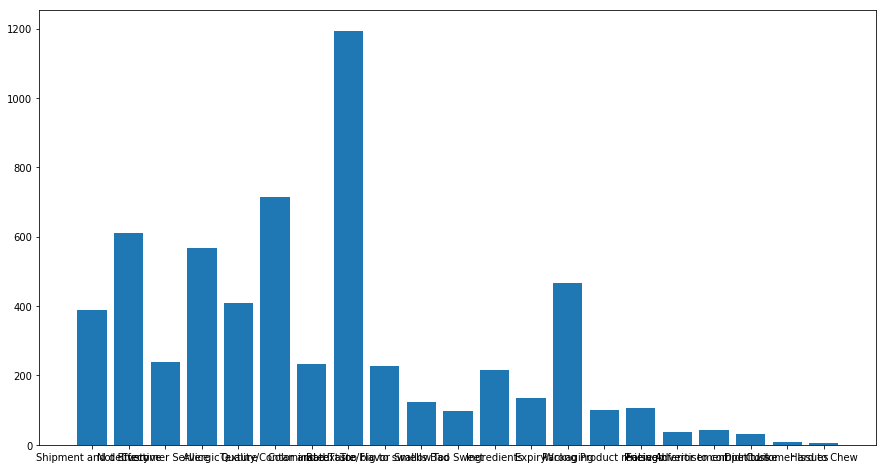

In [7]:
import matplotlib.pyplot as plt

gk = []
k = reviews.topic.unique()
for i in k:
  gk.append(topics.count(i))

plt.figure(figsize=(15,8))
plt.bar(k,gk)

The graph tell us that there are few samples that have very less data, hence  we oversamle the data using SMOTE, and then undersample the data using Tomek

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

sm = SMOTE(random_state=40, k_neighbors=1)

smote_tomek = SMOTETomek(random_state=0, smote=sm)

X_train_res, y_train_res = smote_tomek.fit_resample(vectors, topics)

vectors_train, vectors_test, topics_train, topics_test = train_test_split(X_train_res, y_train_res, random_state = 40)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


I am using XGBoost to train the data with default sklearn parameters, the classification reports gives us precision, recall, f1 score of each label.

In [9]:
from xgboost import XGBClassifier
classifierXGB = XGBClassifier(silent=0)
classifierXGB.fit(vectors_train, topics_train)

# Predict with the testing set
topics_pred = classifierXGB.predict(vectors_test)

# ...and measure the accuracy of the results
from sklearn.metrics import classification_report
print(classification_report(topics_test, topics_pred))

                         precision    recall  f1-score   support

               Allergic       0.74      0.61      0.67       274
       Bad Taste/Flavor       0.62      0.42      0.50       300
      Color and texture       0.66      0.85      0.74       281
        Customer Issues       1.00      1.00      1.00       304
       Customer Service       0.71      0.69      0.70       292
            Didn't Like       0.96      0.99      0.97       296
                 Expiry       0.92      0.96      0.94       313
    False Advertisement       0.97      1.00      0.99       302
           Hard to Chew       1.00      1.00      1.00       306
Inferior to competitors       0.95      0.99      0.97       273
            Ingredients       0.80      0.72      0.76       319
          Not Effective       0.67      0.73      0.70       278
              Packaging       0.76      0.74      0.75       314
                Pricing       0.89      0.96      0.92       290
   Quality/Contaminated 

Read the test Data

In [0]:
test = pd.read_csv('/content/drive/My Drive/Dataset/test.csv')

Filter the data similar to the train data

In [0]:
# Remove the first row, since it only has the labels
reviews =test.copy()

texts = [row[1][0] for row in reviews.iterrows()]
#topics = [row[1][2] for row in reviews.iterrows()]

# Process the texts to so they are ready for training
# But transform the list of words back to string format to feed it to sklearn
texts = [" ".join(process_text(text)) for text in texts]

Transform the test statements using previously trained TFIDF vector, predict the output, then submit it in CSV format

In [0]:
v = matrix.transform(texts)
xg = classifierXGB.predict(v)
testxgb = test.copy()
testxgb['topic'] = xg
testxgb.to_csv('submission.csv', index=False)